## Neural Networks Example, Estimation of Aleatoric Uncertainty in Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset

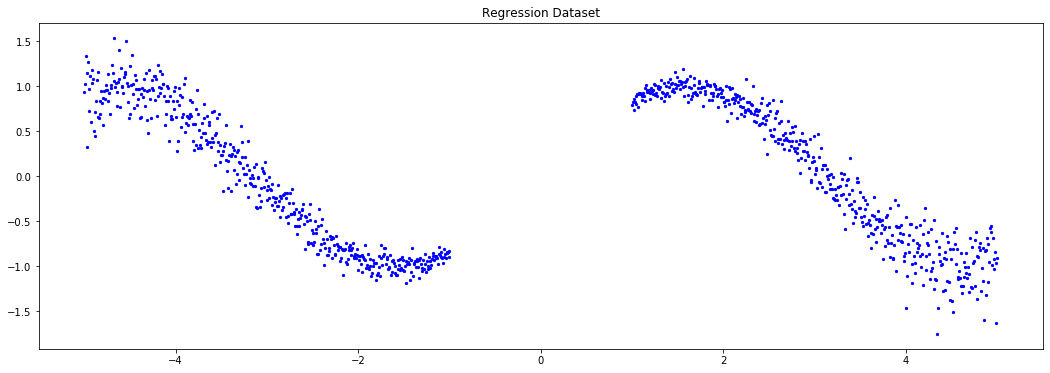

In [2]:
# Create 1000 data points in range(-5, -1) and range(1, 5)
X = np.concatenate([np.linspace(-5, -1, 500), np.linspace(1, 5, 500)])
Y = np.sin(X) + np.random.randn(*X.shape) * X/20

plt.figure(figsize=[18, 6])
plt.title('Regression Dataset')
plt.scatter(X, Y, s=5, color='blue')
plt.show()

## Create Neural Network Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 16), nn.ReLU(),
                               nn.Linear(16, 16), nn.ReLU(),
                               nn.Linear(16, 16), nn.ReLU(),
                               nn.Linear(16, 16), nn.ReLU(),
                               nn.Linear(16, 2))

    def get_loss(self, y, mean, logstd):
        # y : (B, 1)
        # mean : (B, 1)
        # logstd : (B, 1)
        
        negative_log_likelihood = logstd + 0.5 * np.log(2 * np.pi) + 0.5 * ((y - mean) ** 2) / (torch.exp(logstd) ** 2)               
        return torch.mean(negative_log_likelihood)
        
    def forward(self, x):
        # x : (B, 1)
        
        # (B, 2)
        output = self.net(x)
        # (B, 1), (B, 1)
        mean, logstd = output[:, 0:1], output[:, 1:2]
        
        return mean, logstd


## Initialize the Model

In [12]:
model = Model()
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-2)
print(optimizer)

step = 0

print('done')

Model(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
done


## Main Train Loop

In [13]:
from IPython import display
import matplotlib.pyplot as plt

X_tensor = torch.from_numpy(X).float()[:, None]
Y_tensor = torch.from_numpy(Y).float()[:, None]

# Set the model to train mode
model.train()

for _ in range(5000):
    # Set all gradients of the model to zero
    model.zero_grad()
    
    # Input X_tensor and get mean, logstd of Y
    mean, logstd = model(X_tensor)

    loss = model.get_loss(Y_tensor, mean, logstd)
    
    # Update the gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()

    if step % 100 == 0:
        print('step :', step, 'loss :', loss.item())
    
    step += 1


step : 0 loss : 1.1911194324493408
step : 100 loss : -0.505098283290863
step : 200 loss : -0.5245543718338013
step : 300 loss : -0.5607300996780396
step : 400 loss : -0.5677309632301331
step : 500 loss : -0.5723879933357239
step : 600 loss : -0.57599937915802
step : 700 loss : -0.5781015157699585
step : 800 loss : -0.5783576369285583
step : 900 loss : -0.5777043700218201
step : 1000 loss : -0.5568040609359741
step : 1100 loss : -0.5624462962150574
step : 1200 loss : -0.5831203460693359
step : 1300 loss : -0.5582273006439209
step : 1400 loss : -0.5772625207901001
step : 1500 loss : -0.584265947341919
step : 1600 loss : -0.5814650058746338
step : 1700 loss : -0.5869882106781006
step : 1800 loss : -0.5857909917831421
step : 1900 loss : -0.5883721113204956
step : 2000 loss : -0.58217453956604
step : 2100 loss : -0.5898233652114868
step : 2200 loss : -0.5829069018363953
step : 2300 loss : -0.5920703411102295
step : 2400 loss : -0.5924445390701294
step : 2500 loss : -0.5398447513580322
step 

## Regression Result

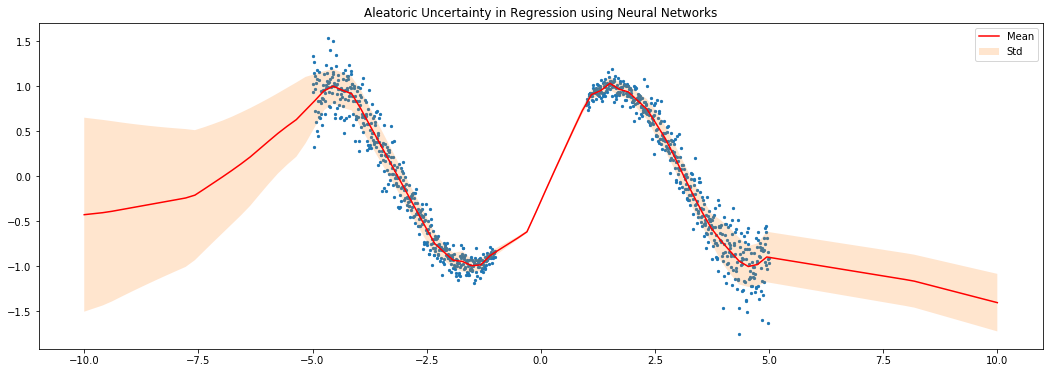

In [14]:
# Create 100 datapoints for test in range(-10, 10)
_X_test = np.linspace(-10, 10, 100)
X_test = torch.from_numpy(_X_test).float()[:, None]

# Input X_test to model and get mean and logstd of Y
Y_mean, Y_logstd = model(X_test)
_Y_mean = Y_mean[:, 0].data.cpu().numpy()
_Y_std = np.exp(Y_logstd[:, 0].data.cpu().numpy())

# Plot the regression result
plt.figure(figsize=[18, 6])
plt.title('Aleatoric Uncertainty in Regression using Neural Networks')
plt.scatter(X, Y, s=5)
plt.plot(_X_test,_Y_mean, color='red', alpha=1, label='Mean')
plt.fill_between(_X_test, _Y_mean + _Y_std, _Y_mean - _Y_std, alpha=0.2, label='Std')
plt.legend()
plt.show()